In [1]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split

# 创建随机数据集
X, y = make_classification(
    n_samples=1000, # 数据集大小
    n_features=16, # 特征数，即数据维度
    n_informative=5, # 有效特征个数
    n_redundant=2, # 冗余特征个数，为有效特征的随机线性组合
    n_classes=2, # 类别数
    flip_y=0.1, # 类别随机的样本个数，该值越大，分类越困难
    random_state=0 # 随机种子
)

print(X.shape)

(1000, 16)


In [2]:
class RandomForest():

    def __init__(self, n_trees=10, max_features='sqrt'):
        # max_features是DTC的参数，表示结点分裂时随机采样的特征个数
        # sqrt代表取全部特征的平方根，None代表取全部特征，log2代表取全部特征的对数
        self.n_trees = n_trees
        self.oob_score = 0
        self.trees = [DTC(max_features=max_features)
            for _ in range(n_trees)]

    # 用X和y训练模型
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = np.unique(y).shape[0]   
        # 集成模型的预测，累加单个模型预测的分类概率，再取较大值作为最终分类
        ensemble = np.zeros((n_samples, self.n_classes))
            
        for tree in self.trees:
            # 自举采样，该采样允许重复
            idx = np.random.randint(0, n_samples, n_samples)
            # 没有被采到的样本
            unsampled_mask = np.bincount(idx, minlength=n_samples) == 0
            unsampled_idx = np.arange(n_samples)[unsampled_mask]
            # 训练当前决策树
            tree.fit(X[idx], y[idx])
            # 累加决策树对OOB样本的预测
            ensemble[unsampled_idx] += tree.predict_proba(X[unsampled_idx])
        # 计算OOB分数，由于是分类任务，我们用正确率来衡量
        self.oob_score = np.mean(y == np.argmax(ensemble, axis=1))
    
    # 预测类别
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)
    
    def predict_proba(self, X):
        # 取所有决策树预测概率的平均
        ensemble = np.mean([tree.predict_proba(X)
            for tree in self.trees], axis=0)
        return ensemble
    
    # 计算正确率
    def score(self, X, y):
        return np.mean(y == self.predict(X))

100%|███████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s, n_tree=96, train_score=1, oob_score=0.897]


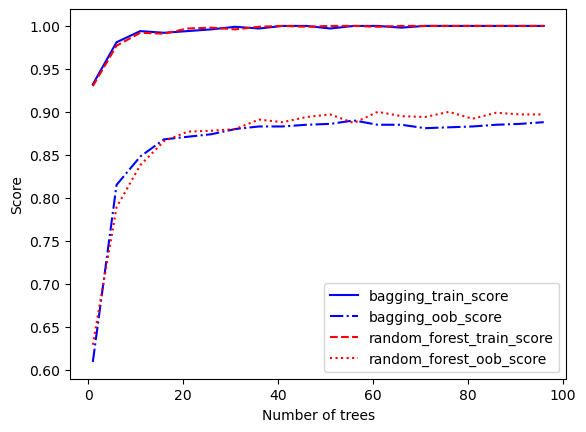

In [3]:
# 算法测试与可视化
num_trees = np.arange(1, 101, 5)
np.random.seed(0)
plt.figure()

# bagging算法
oob_score = []
train_score = []
with tqdm(num_trees) as pbar:
    for n_tree in pbar:
        rf = RandomForest(n_trees=n_tree, max_features=None)
        rf.fit(X, y)
        train_score.append(rf.score(X, y))
        oob_score.append(rf.oob_score)
        pbar.set_postfix({
            'n_tree': n_tree, 
            'train_score': train_score[-1], 
            'oob_score': oob_score[-1]
        })
plt.plot(num_trees, train_score, color='blue', 
    label='bagging_train_score')
plt.plot(num_trees, oob_score, color='blue', linestyle='-.', 
    label='bagging_oob_score')

# 随机森林算法
oob_score = []
train_score = []
with tqdm(num_trees) as pbar:
    for n_tree in pbar:
        rf = RandomForest(n_trees=n_tree, max_features='sqrt')
        rf.fit(X, y)
        train_score.append(rf.score(X, y))
        oob_score.append(rf.oob_score)
        pbar.set_postfix({
            'n_tree': n_tree, 
            'train_score': train_score[-1], 
            'oob_score': oob_score[-1]
        })
plt.plot(num_trees, train_score, color='red', linestyle='--', 
    label='random_forest_train_score')
plt.plot(num_trees, oob_score, color='red', linestyle=':', 
    label='random_forest_oob_score')

plt.ylabel('Score')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

In [4]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

bc = BaggingClassifier(n_estimators=100, oob_score=True, random_state=0)
bc.fit(X, y)
print('bagging：', bc.oob_score_)

rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt', 
    oob_score=True, random_state=0)
rfc.fit(X, y)
print('随机森林：', rfc.oob_score_)

bagging： 0.885
随机森林： 0.897


In [5]:
from sklearn.model_selection import KFold
from sklearn.base import clone

# 堆垛分类器，继承sklearn中的集成分类器基类EnsembleClassifier
class StackingClassifier():

    def __init__(
        self, 
        classifiers, # 基础分类器
        meta_classifier, # 元分类器
        concat_feature=False, # 是否将原始数据拼接在新数据上
        kfold=5 # K折交叉验证
    ):
        self.classifiers = classifiers
        self.meta_classifier = meta_classifier
        self.concat_feature = concat_feature
        self.kf = KFold(n_splits=kfold)
        # 为了在测试时计算平均，我们需要保留每个分类器
        self.k_fold_classifiers = []
        
    def fit(self, X, y):
        # 用X和y训练基础分类器和元分类器
        n_samples, n_features = X.shape
        self.n_classes = np.unique(y).shape[0]
        
        if self.concat_feature:
            features = X
        else:
            features = np.zeros((n_samples, 0))
        for classifier in self.classifiers:
            self.k_fold_classifiers.append([])
            # 训练每个基础分类器
            predict_proba = np.zeros((n_samples, self.n_classes))
            for train_idx, test_idx in self.kf.split(X):
                # 交叉验证
                clf = clone(classifier)
                clf.fit(X[train_idx], y[train_idx])
                predict_proba[test_idx] = clf.predict_proba(X[test_idx])
                self.k_fold_classifiers[-1].append(clf)
            features = np.concatenate([features, predict_proba], axis=-1)
        # 训练元分类器
        self.meta_classifier.fit(features, y)
    
    def _get_features(self, X):
        # 计算输入X的特征
        if self.concat_feature:
            features = X
        else:
            features = np.zeros((X.shape[0], 0))
        for k_classifiers in self.k_fold_classifiers:
            k_feat = np.mean([clf.predict_proba(X)
                for clf in k_classifiers], axis=0)
            features = np.concatenate([features, k_feat], axis=-1)
        return features
    
    def predict(self, X):
        return self.meta_classifier.predict(self._get_features(X))
        
    def score(self, X, y):
        return self.meta_classifier.score(self._get_features(X), y)

In [6]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC

# 划分训练集和测试集
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

# 基础分类器
rf = RFC(n_estimators=10, max_features='sqrt', 
    random_state=0).fit(X_train, y_train)
knc = KNC().fit(X_train, y_train)
# multi_class='ovr'表示二分类问题
lr = LR(solver='liblinear', multi_class='ovr', 
    random_state=0).fit(X_train, y_train)
print('随机森林：', rf.score(X_test, y_test))
print('KNN：', knc.score(X_test, y_test))
print('逻辑斯谛回归：', lr.score(X_test, y_test))
# 元分类器
meta_lr = LR(solver='liblinear', multi_class='ovr', random_state=0)

sc = StackingClassifier([rf, knc, lr], meta_lr, concat_feature=False)
sc.fit(X_train, y_train)
print('Stacking分类器：', sc.score(X_test, y_test))

# 带原始特征的stacking分类器
sc_concat = StackingClassifier([rf, knc, lr], meta_lr, concat_feature=True)
sc_concat.fit(X_train, y_train)
print('带原始特征的Stacking分类器：', sc_concat.score(X_test, y_test))

随机森林： 0.895
KNN： 0.9
逻辑斯谛回归： 0.855
Stacking分类器： 0.91
带原始特征的Stacking分类器： 0.905


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.40s/it]


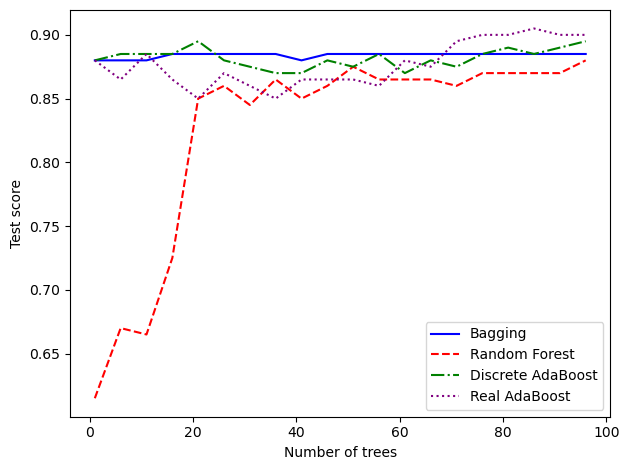

In [7]:
from sklearn.ensemble import AdaBoostClassifier

# 初始化stump
stump = DTC(max_depth=1, min_samples_leaf=1, random_state=0)

# 弱分类器个数
M = np.arange(1, 101, 5)
bg_score = []
rf_score = []
dsc_ada_score = []
real_ada_score = []
plt.figure()

with tqdm(M) as pbar:
    for m in pbar:
        # bagging算法
        bc = BaggingClassifier(estimator=stump, 
            n_estimators=m, random_state=0)
        bc.fit(X_train, y_train)
        bg_score.append(bc.score(X_test, y_test))
        # 随机森林算法
        rfc = RandomForestClassifier(n_estimators=m, max_depth=1, 
            min_samples_leaf=1, random_state=0)
        rfc.fit(X_train, y_train)
        rf_score.append(rfc.score(X_test, y_test))
        # 离散 AdaBoost，SAMME是分步加性模型（stepwise additive model）的缩写
        dsc_adaboost = AdaBoostClassifier(estimator=stump, 
            n_estimators=m, algorithm='SAMME', random_state=0)
        dsc_adaboost.fit(X_train, y_train)
        dsc_ada_score.append(dsc_adaboost.score(X_test, y_test))
        # 实 AdaBoost，SAMME.R表示弱分类器输出实数
        real_adaboost = AdaBoostClassifier(estimator=stump, 
            n_estimators=m, algorithm='SAMME.R', random_state=0)
        real_adaboost.fit(X_train, y_train)
        real_ada_score.append(real_adaboost.score(X_test, y_test))

# 绘图
plt.plot(M, bg_score, color='blue', label='Bagging')
plt.plot(M, rf_score, color='red', ls='--', label='Random Forest')
plt.plot(M, dsc_ada_score, color='green', ls='-.', label='Discrete AdaBoost')
plt.plot(M, real_ada_score, color='purple', ls=':', label='Real AdaBoost')
plt.xlabel('Number of trees')
plt.ylabel('Test score')
plt.legend()
plt.tight_layout()
plt.savefig('output_26_1.png')
plt.savefig('output_26_1.pdf')
plt.show()

In [8]:
# 安装并导入xgboost库
!pip install xgboost
import xgboost as xgb
from sklearn.datasets import make_friedman1
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, \
    StackingRegressor, AdaBoostRegressor

# 生成回归数据集
reg_X, reg_y = make_friedman1(
    n_samples=2000, # 样本数目
    n_features=100, # 特征数目
    noise=0.5, # 噪声的标准差
    random_state=0 # 随机种子
)

# 划分训练集与测试集
reg_X_train, reg_X_test, reg_y_train, reg_y_test = \
    train_test_split(reg_X, reg_y, test_size=0.2, random_state=0)

In [9]:
def rmse(regressor):
    # 计算regressor在测试集上的RMSE
    y_pred = regressor.predict(reg_X_test)
    return np.sqrt(np.mean((y_pred - reg_y_test) ** 2))

# XGBoost回归树
xgbr = xgb.XGBRegressor(
    n_estimators=100, # 弱分类器数目
    max_depth=1, # 决策树最大深度
    learning_rate=0.5, # 学习率
    gamma=0.0, # 对决策树叶结点数目的惩罚系数，当弱分类器为stump时不起作用
    reg_lambda=0.1, # L2正则化系数
    subsample=0.5, # 与随机森林类似，表示采样特征的比例
    objective='reg:squarederror', # MSE损失函数
    eval_metric='rmse', # 用RMSE作为评价指标
    random_state=0 # 随机种子
)

xgbr.fit(reg_X_train, reg_y_train)
print(f'XGBoost：{rmse(xgbr):.3f}')

# KNN回归
knnr = KNeighborsRegressor(n_neighbors=5).fit(reg_X_train, reg_y_train)
print(f'KNN：{rmse(knnr):.3f}')

# 线性回归
lnr = LinearRegression().fit(reg_X_train, reg_y_train)
print(f'线性回归：{rmse(lnr):.3f}')

# bagging
stump_reg = DecisionTreeRegressor(max_depth=1, 
    min_samples_leaf=1, random_state=0)
bcr = BaggingRegressor(estimator=stump_reg, 
    n_estimators=100, random_state=0)
bcr.fit(reg_X_train, reg_y_train)
print(f'Bagging：{rmse(bcr):.3f}')

# 随机森林
rfr = RandomForestRegressor(n_estimators=100, max_depth=1, 
    max_features='sqrt', random_state=0)
rfr.fit(reg_X_train, reg_y_train)
print(f'随机森林：{rmse(rfr):.3f}')

# 堆垛，默认元学习器为带L2正则化约束的线性回归
stkr = StackingRegressor(estimators=[
    ('knn', knnr), 
    ('ln', lnr), 
    ('rf', rfr)
])
stkr.fit(reg_X_train, reg_y_train)
print(f'Stacking：{rmse(stkr):.3f}')

# 带有输入特征的堆垛
stkr_pt = StackingRegressor(estimators=[
    ('knn', knnr), 
    ('ln', lnr), 
    ('rf', rfr)
], passthrough=True)
stkr_pt.fit(reg_X_train, reg_y_train)
print(f'带输入特征的Stacking：{rmse(stkr_pt):.3f}')

# AdaBoost，回归型AdaBoost只有连续型，没有离散型
abr = AdaBoostRegressor(estimator=stump_reg, n_estimators=100, 
    learning_rate=1.5, loss='square', random_state=0)
abr.fit(reg_X_train, reg_y_train)
print(f'AdaBoost：{rmse(abr):.3f}')

XGBoost：1.652
KNN：4.471
线性回归：2.525
Bagging：4.042
随机森林：4.514
Stacking：2.231
带输入特征的Stacking：2.288
AdaBoost：3.116
